# Descripción de la señal EMG

Este código es utilizado para la lectura de una señal .emt que corresponde a una señal de EMG tomada de un ciclista pedaleando, y adquirida a través del equipo de EMG del laboratorio de Análisis de Movimiento de la UAM.

El encabezado del archivo si es abierto con un procesador de texto es como sigue (este encabezado puede cambiar entre los diferentes archivos):

BTS ASCII format

Type:         	Emg tracks
Measure unit: 	mV

Tracks:       	8

Frequency:    	1000 Hz

Frames:       	11933

Start time:   	0.000


Frame	 | Time	| Right Tibialis anterior	| Right Vastus medialis	| Right Rectus femoris	| Right Gastrocnemius lateralis	| Left Tibialis anterior |	Left Vastus medialis	| Left Rectus femoris	| Left Gastrocnemius lateralis

Donde cada variable mencionada anteriormente corresponde a 8 canales capturados, Time es el vector de tiempo de adquisición, y Frame es la muestra es cada instante de tiempo.

# Proceso para cargar la señal

Paso 1. Montar la unidad de drive para leer los archivos.

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


Paso 2. Introducir el path o directorio donde estan almancenados los datos



In [3]:
cd /content/drive/MyDrive/EMG

/content/drive/.shortcut-targets-by-id/14Rp5JdO5nBi6Rg5DQcI_dqBg3kyiCD7U/EMG


Paso 3. Cargar los datos

In [4]:
import pandas as pd

# Ruta del archivo
file_path = 'EMG trial3.emt'

# Cargar el archivo, saltando las líneas del encabezado que no contienen datos
data_start_line = 10  # Salta las primeras 10 líneas para llegar a los datos

# Leer el archivo como un archivo delimitado por espacios
signal_data = pd.read_csv(file_path, sep='\s+', skiprows=data_start_line, header=None)

# Limpiar las filas que contienen información no numérica
def is_numeric_row(row):
    try:
        # Intentar convertir las columnas a datos numéricos, ignorando las dos primeras (Frame y Time)
        row.iloc[2:].astype(float)
        return True
    except ValueError:
        return False

# Aplicar la función para filtrar solo las filas numéricas
numeric_rows = signal_data.apply(is_numeric_row, axis=1)
signal_data_filtered = signal_data[numeric_rows].reset_index(drop=True)

# Convertir a valores numéricos
signal_data_filtered = signal_data_filtered.apply(pd.to_numeric)

# Definir los nombres de las columnas correctos, incluidos los canales EMG
column_names_corrected = ['Frame', 'Time', 'Right Tibialis anterior', 'Right Vastus medialis',
                          'Right Rectus femoris', 'Right Gastrocnemius lateralis',
                          'Left Tibialis anterior', 'Left Vastus medialis',
                          'Left Rectus femoris', 'Left Gastrocnemius lateralis']

# Subset del DataFrame para ajustarlo a las señales y reasignar nombres de columnas
signal_data_filtered = signal_data_filtered.iloc[:, :len(column_names_corrected)]
signal_data_filtered.columns = column_names_corrected

# Visualizar las primeras filas del DataFrame limpio
print(signal_data_filtered.head())

   Frame   Time  Right Tibialis anterior  Right Vastus medialis  \
0      0  0.000                    0.044                  0.014   
1      1  0.001                   -0.009                  0.011   
2      2  0.002                   -0.056                  0.012   
3      3  0.003                   -0.063                  0.029   
4      4  0.004                   -0.069                  0.027   

   Right Rectus femoris  Right Gastrocnemius lateralis  \
0                -0.003                  -4.575653e+26   
1                 0.005                   1.003733e+27   
2                -0.004                   9.809569e+27   
3                -0.010                   2.605604e+25   
4                -0.002                  -1.375238e+26   

   Left Tibialis anterior  Left Vastus medialis  Left Rectus femoris  \
0                  -0.001                -0.037               -0.028   
1                  -0.005                -0.081               -0.005   
2                  -0.055       

Paso 4. Graficar un canal de la señal EMG

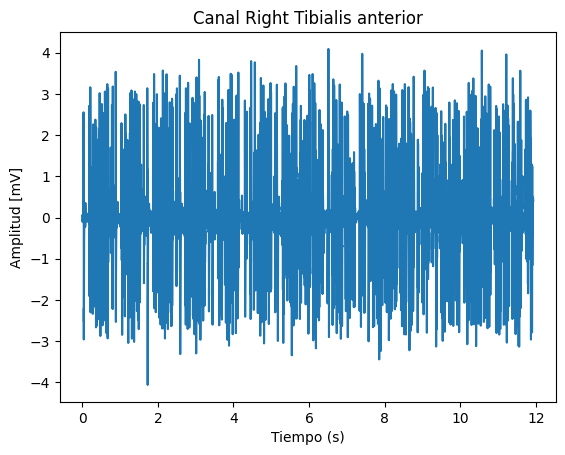

In [5]:
import matplotlib.pyplot as plt

ch1 = signal_data_filtered['Right Tibialis anterior'] # Canal seleccionado.
time = signal_data_filtered['Time'] # Vector de tiempo

plt.plot(time,ch1)
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud [mV]')
plt.title('Canal Right Tibialis anterior')
plt.show()

##**Pre Filtrado**

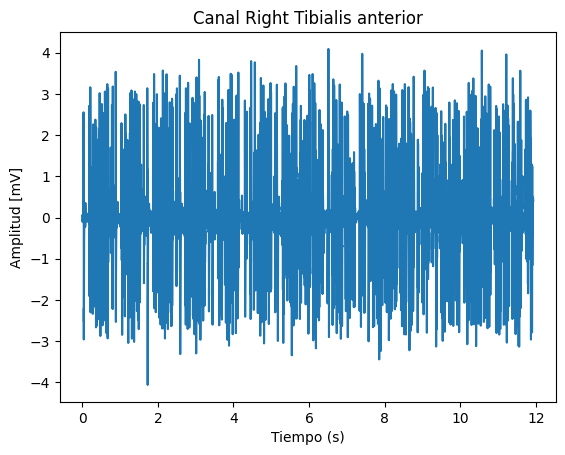

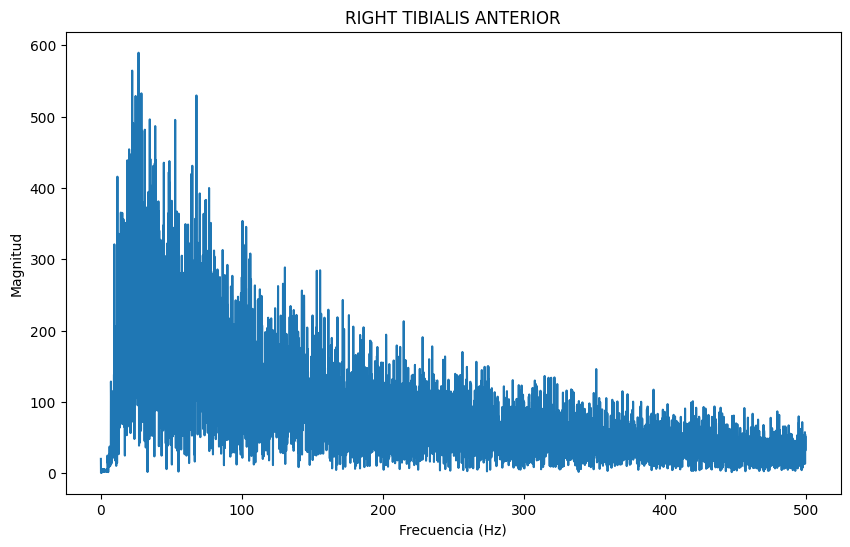

In [6]:
#MUSCULO: Tibialis anterior
#RIGHT (Derecha)
import matplotlib.pyplot as plt
import numpy as np

ch1 = signal_data_filtered['Right Tibialis anterior'] # Canal seleccionado.
time = signal_data_filtered['Time'] # Vector de tiempo
fs = 1000

#Grafica en el espectro del tiempo
plt.plot(time,ch1)
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud [mV]')
plt.title('Canal Right Tibialis anterior')
plt.show()

fft_valores = np.fft.fft(ch1) #HACEMOS LA FFT
frecs = np.fft.fftfreq(len(ch1), 1/fs)

#Grafica en el espectro de la frecuencia (FFT)
fft_magnitud = np.abs(fft_valores) #CALCULAMOS LA MAGNITUD PARA PODER GRAFICAR
plt.figure(figsize=(10, 6))
plt.plot(frecs[:len(frecs)//2], fft_magnitud[:len(frecs)//2])  #AJUSTAMOS VER SOLO EL ESPECTRO POSITIVO
plt.title('RIGHT TIBIALIS ANTERIOR')
plt.xlabel('Frecuencia (Hz)')
plt.ylabel('Magnitud')
plt.show()

##*Filtro FIR Equirruple**

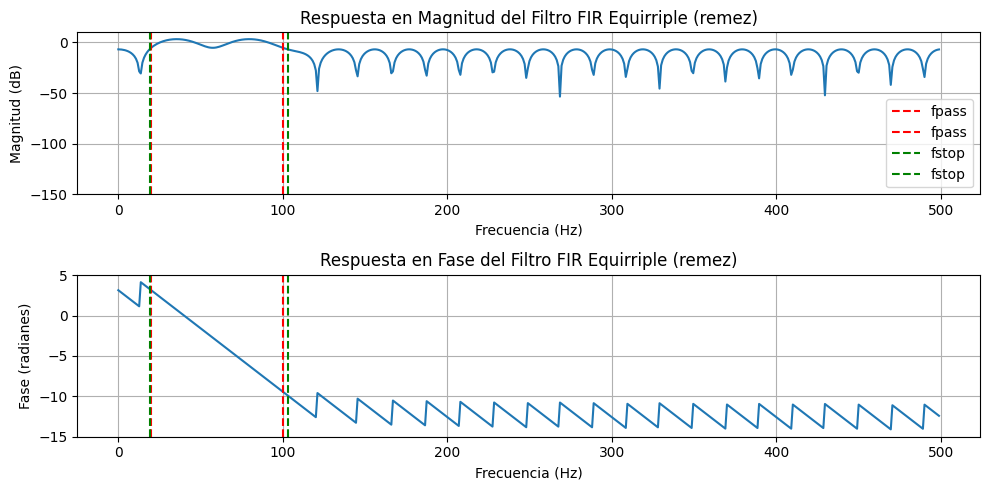

In [14]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt

# Especificaciones del filtro FIR Equirriple (remez)
fs = 1000  # Frecuencia de muestreo
fpass = [20, 100]  # Frecuencias de paso
fstop = [19, 103]  # Frecuencias de rechazo
gpass = 1  # Rizado de banda pasante
gstop = 60  # Atenuación de banda rechazada

# Orden del filtro (ajustar según necesidades)
order = 50
numtaps = order + 1

# Diseño del filtro FIR Equirriple usando remez
b = signal.remez(numtaps, [0, fstop[0], fpass[0], fpass[1], fstop[1], 0.5 * fs], [0, 1, 0], fs=fs)

# Respuesta en frecuencia del filtro
w, h = signal.freqz(b)

# Gráfica de magnitud
plt.figure(figsize=(10, 5))
plt.subplot(2, 1, 1)
plt.plot(w / (2 * np.pi) * fs, 20 * np.log10(abs(h)))
plt.title('Respuesta en Magnitud del Filtro FIR Equirriple (remez)')
plt.xlabel('Frecuencia (Hz)')
plt.ylabel('Magnitud (dB)')
plt.grid(True)

# Líneas de referencia
plt.axvline(fpass[0], color='r', linestyle='--', label='fpass')
plt.axvline(fpass[1], color='r', linestyle='--', label='fpass')
plt.axvline(fstop[0], color='g', linestyle='--', label='fstop')
plt.axvline(fstop[1], color='g', linestyle='--', label='fstop')

plt.legend()
plt.ylim([-150, 10])

# Gráfica de fase
plt.subplot(2, 1, 2)
plt.plot(w / (2 * np.pi) * fs, np.unwrap(np.angle(h)))
plt.title('Respuesta en Fase del Filtro FIR Equirriple (remez)')
plt.xlabel('Frecuencia (Hz)')
plt.ylabel('Fase (radianes)')
plt.grid(True)

# Líneas de referencia
plt.axvline(fpass[0], color='r', linestyle='--', label='fpass')
plt.axvline(fpass[1], color='r', linestyle='--', label='fpass')
plt.axvline(fstop[0], color='g', linestyle='--', label='fstop')
plt.axvline(fstop[1], color='g', linestyle='--', label='fstop')

plt.tight_layout()
plt.show()

#**Aplicación Fltro Tiempo**

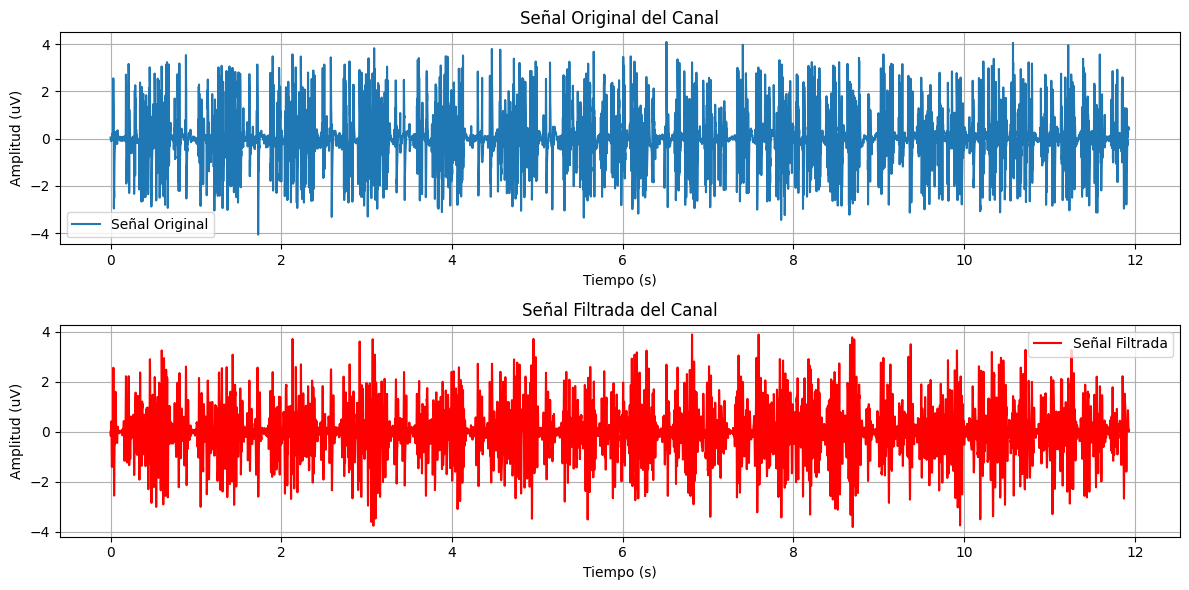

In [15]:
# Aplicar el filtro a la señal usando filtfilt
filtered_signal = signal.filtfilt(b, 1, ch1)  # `a=1` para filtro FIR

# Graficar señal original y filtrada
plt.figure(figsize=(12, 6))

# Señal original
plt.subplot(2, 1, 1)
plt.plot(time, ch1, label='Señal Original')
plt.title(f'Señal Original del Canal')
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud (uV)')
plt.grid(True)
plt.legend()

# Señal filtrada
plt.subplot(2, 1, 2)
plt.plot(time, filtered_signal, label='Señal Filtrada', color='red')
plt.title(f'Señal Filtrada del Canal')
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud (uV)')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


#**Aplicación Fltro Espectro**

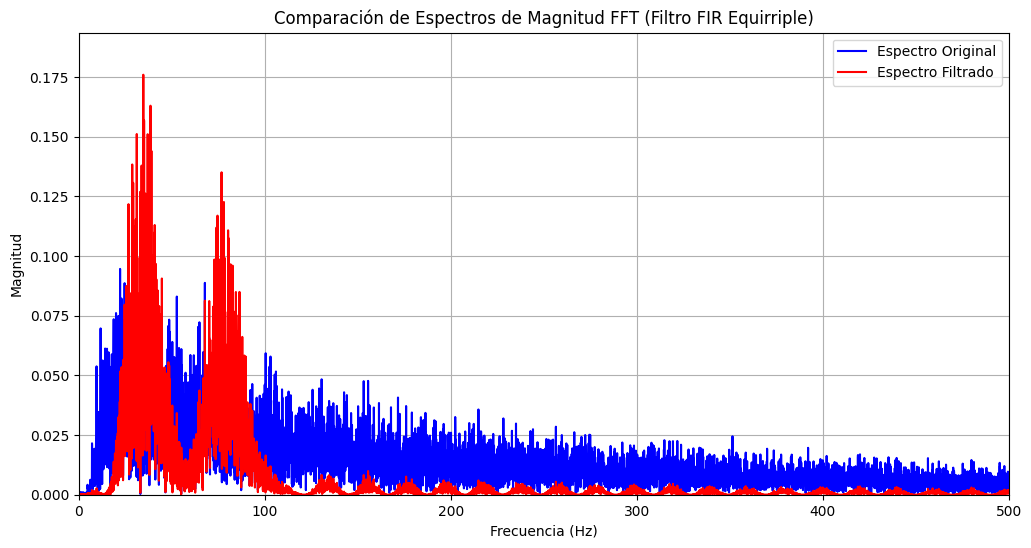

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

# Especificaciones
fs = 1000  # Frecuencia de muestreo
N = len(ch1)  # Número de muestras de la señal

# Componente DC para la señal original
comp_DC_original = np.mean(ch1)

# FFT de la señal original
fft_original = np.fft.fft(ch1 - comp_DC_original, axis=0)
frequencies = np.fft.fftfreq(N, d=1/fs)
fft_original_magnitude = 2 * np.abs(fft_original[:N // 2]) / N

# Componente DC para la señal filtrada
comp_DC_filtered = np.mean(filtered_signal)

# FFT de la señal filtrada
fft_filtered = np.fft.fft(filtered_signal - comp_DC_filtered, axis=0)
fft_filtered_magnitude = 2 * np.abs(fft_filtered[:N // 2]) / N

# Graficar espectros de magnitud
plt.figure(figsize=(12, 6))
plt.plot(frequencies[:N // 2], fft_original_magnitude, label='Espectro Original', color='blue')
plt.plot(frequencies[:N // 2], fft_filtered_magnitude, label='Espectro Filtrado', color='red')
plt.title("Comparación de Espectros de Magnitud FFT (Filtro FIR Equirriple)")
plt.xlabel("Frecuencia (Hz)")
plt.ylabel("Magnitud")
plt.xlim([0, fs / 2])
plt.ylim([0, max(fft_original_magnitude.max(), fft_filtered_magnitude.max()) * 1.1])
plt.legend()
plt.grid(True)
plt.show()

#**Ventaneo**

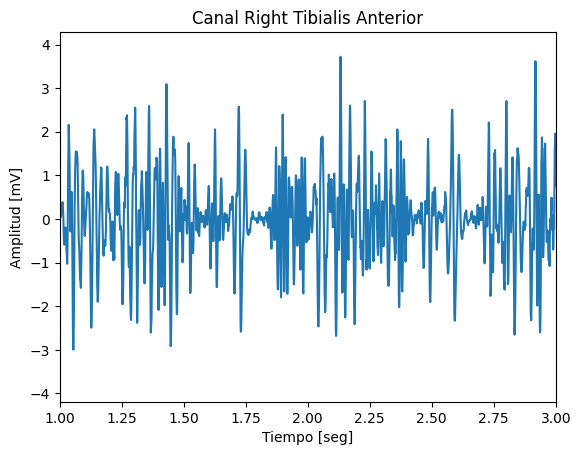

In [20]:
plt.plot(time, filtered_signal)
plt.xlabel('Tiempo [seg]')
plt.ylabel('Amplitud [mV]')
plt.title('Canal Right Tibialis Anterior')
plt.xlim(1,3) # con estos valores se determina el zoom
plt.show()

#**Ventaneo en el espectro de la frecuencia**

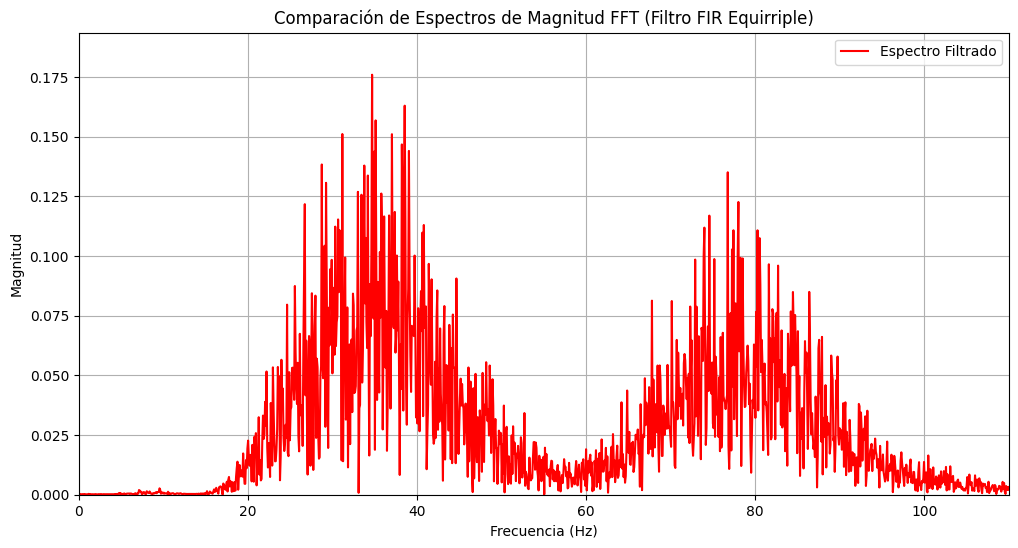

In [21]:
plt.figure(figsize=(12, 6))
plt.plot(frequencies[:N // 2], fft_filtered_magnitude, label='Espectro Filtrado', color='red')
plt.title("Comparación de Espectros de Magnitud FFT (Filtro FIR Equirriple)")
plt.xlabel("Frecuencia (Hz)")
plt.ylabel("Magnitud")
plt.xlim([0, 110])
plt.ylim([0, max(fft_original_magnitude.max(), fft_filtered_magnitude.max()) * 1.1])
plt.legend()
plt.grid(True)
plt.show()